# Large scale text analysis with deep learning

Today we're gonna apply the newly learned tools for the task of predicting job salary.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

_Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the core assignment idea._

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download and unpack the data from [here](https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=0). 

You can also get it from [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7) the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [40]:
!curl -L https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=1 -o Train_rev1.csv.tar.gz
!tar -xvzf ./Train_rev1.csv.tar.gz
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data.shape

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   145    0   145    0     0    212      0 --:--:-- --:--:-- --:--:--   212
100   342  100   342    0     0    318      0  0:00:01  0:00:01 --:--:--   318
100  119M  100  119M    0     0  16.7M      0  0:00:07  0:00:07 --:--:-- 26.2M
Train_rev1.csv


(244768, 12)

One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

In [41]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


In [42]:
# dict(data.SourceName.value_counts())
# dict(data.LocationNormalized.value_counts())
# data['SalaryNormalized']

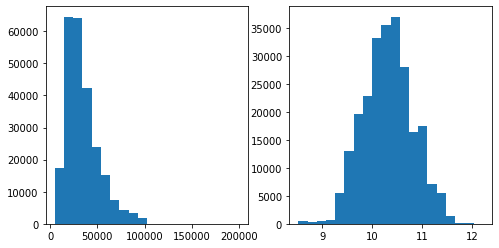

In [43]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [44]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
6835,64144821,Benelux Team Leader London,Salary: &pound**** Company: Montreal Associate...,London,London,full_time,permanent,Montreal Associates,HR & Recruitment Jobs,50000,50000,strike-jobs.co.uk,10.819798
199478,71851044,Sales Executive / Sales Consultant,Bon Accord Life are seeking talented salespeop...,Stirling Stirlingshire Scotland,UK,NaN,permanent,Bon Accord Life,Accounting & Finance Jobs,"30,000 per annum OTE (Basic salary plus bonus)",30000,totaljobs.com,10.308986
149170,70762200,Maths Teacher $**** per month tax free Saudi...,We are urgently seeking Maths Teachers for a l...,"Saudi Arabia, Non UK",UK,NaN,contract,ITN Mark Education,Teaching Jobs,4000 - 5000/month $8000pm Tax free plus benefits,54000,cv-library.co.uk,10.896758


### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [45]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [46]:
def list_to_str(f):
    def wrapper(sentence):
        res = ' '.join(f(sentence)).lower()
        return res
    return wrapper

In [47]:
data[text_columns] = data[text_columns].fillna('')
data[text_columns] = data[text_columns].astype('string')

In [48]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

# tokenizer.tokenize = list_to_str(tokenizer.tokenize)

In [49]:

# see task above

all_tk = []
for col in text_columns:
    new_col = []
    new_col1 = []
    for each in data[col]:
        tk = ""
        rw = ""
        if pd.isna(each)==False:
            tk = tokenizer.tokenize(each.lower())
        new_col1.append(" ".join(tk))
        for word in tk:
            all_tk.append(word)
    data[col] = new_col1


# for column in text_columns:
#     for i, sentence in enumerate(data[column]):
#         data.loc[i, column] = tokenizer.tokenize(sentence)


# title_map = map(tokenizer.tokenize, data['Title'])
# title_list = list(title_map)
# del title_map
# data['Title'] = np.array(title_list)
# del title_list

# fulldescription_map = map(tokenizer.tokenize, data['FullDescription'])
# fulldescription_list = list(fulldescription_map)
# del fulldescription_map
# data['FullDescription'] = np.array(fulldescription_list)
# del fulldescription_list


# data['Title'] = np.stack(list())
# data['FullDescription'] = np.stack(list(map(tokenizer.tokenize, data['FullDescription'].astype('string'))))

In [50]:
del new_col
del new_col1

In [51]:
# data.loc[:,'FullDescription']
# data["FullDescription"][2][:50]

Now we can assume that our text is a space-separated list of tokens:

In [52]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [53]:
from collections import Counter

In [54]:
# Count how many times does each token occur in both "Title" and "FullDescription" in total
# build a dictionary { token -> it's count }
token_counts = Counter(all_tk)

# hint: you may or may not want to use collections.Counter

In [55]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


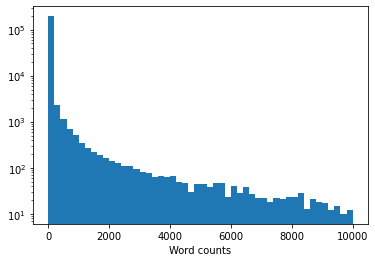

In [56]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

Now filter tokens a list of all tokens that occur at least 10 times.

In [57]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = Counter({k: c for k, c in token_counts.items() if c >= min_count})

In [58]:
# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


In [59]:
tokens[1]

'PAD'

Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [60]:
token_to_id = dict({token: i for (i, token) in enumerate(tokens)})

In [61]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [62]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [63]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


In [64]:
data["Title"]

0                               engineering systems analyst
1                                   stress engineer glasgow
2                          modelling and simulation analyst
3         engineering systems analyst / mathematical mod...
4               pioneer , miser engineering systems analyst
                                ...                        
244763                                   teacher of science
244764                  teacher of business studies and ict
244765                                      english teacher
244766                                      supply teachers
244767                                           accountant
Name: Title, Length: 244768, dtype: object

Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [65]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [66]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [67]:
def make_batch(data, max_len=None, word_dropout=0):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [68]:
batch_example = make_batch(data_train[:3], max_len=10)

In [69]:
batch_example

{'Title': array([[27645, 29893, 33674,     1,     1,     1,     1],
        [29239,   197, 19175, 20042, 15554, 23162,  4051],
        [10609, 30412, 17746,    33,  8705, 29157,    65]], dtype=int32),
 'FullDescription': array([[27645, 29893, 33674, 32939,   982, 27645, 29893, 33674, 16451,
         32939],
        [29239,   197, 19175, 20042, 15554, 23162,  4051, 25511,   907,
            82],
        [30746, 21956, 20601,  6409, 16451,  8165, 27493,   982, 30412,
         17746]], dtype=int32),
 'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'Log1pSalary': array([ 9.71154 , 10.463132, 10.71444 ], dtype=float32)}

In [70]:
# batch_example['Title'][0].shape[0]
# batch_example['FullDescription'][0].shape[0]
# batch_example['Categorical'][0].shape[0]
len(tokens)

34158

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

<img src="https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png" width=600px>

This clearly doesn't fit into keras' __Sequential__ interface. To build such a network, one will have to use __[Keras Functional API](https://keras.io/models/model/)__.

In [71]:
import keras
import keras.layers as L
import tensorflow as tf
import keras.backend as K

In [72]:
K.clear_session()

In [73]:
def build_model(n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
    """ Build a model that maps three data sources to a single linear output: predicted log1p(salary) """
    
    l_title = L.Input(shape=[None], name="Title")
    l_descr = L.Input(shape=[None], name="FullDescription")
    l_categ = L.Input(shape=[n_cat_features], name="Categorical")
    
    # Build your monster!

#     emb_layer_descr = L.Embedding(batch_example['FullDescription'][0].shape[0], 100)(l_descr)
    emb_descr = L.Embedding(len(tokens), 128)(l_descr)
    conv_descr = L.Conv1D(filters=64, kernel_size=2, padding='same')(emb_descr)
    conv_descr = L.Conv1D(filters=128, kernel_size=3, padding='same')(conv_descr)
#     lstm_descr = L.Bidirectional(L.LSTM(10))(conv_descr)
    av_pool_descr = L.GlobalAveragePooling1D()(conv_descr)
    max_pool_descr = L.GlobalMaxPooling1D()(conv_descr)
    concat_descr = L.Concatenate()([av_pool_descr, max_pool_descr])
    dense_descr = L.Dense(64)(concat_descr)

    
#     emb_layer_title = L.Embedding(batch_example['Title'][0].shape[0], 100)(l_title)
    emb_title = L.Embedding(len(tokens), 64)(l_title)
    conv_title = L.Conv1D(filters=64, kernel_size=2)(emb_title)
    conv_title = L.Conv1D(filters=128, kernel_size=3)(conv_title)
#     lstm_title = L.Bidirectional(L.LSTM(7))(conv_title)
    av_pool_title = L.GlobalAveragePooling1D()(conv_title)
    max_pool_title = L.GlobalMaxPooling1D()(conv_title)
    concat_title = L.Concatenate()([av_pool_title, max_pool_title])
    dense_title = L.Dense(64)(concat_title)

    dense1_categ = L.Dense(units=100, activation='relu')(l_categ)

#     concat_layer = L.Concatenate(axis=-1)([lstm_title, lstm_descr, dense1_categ])
    concat_layer = L.Concatenate(axis=-1)([dense_title, dense_descr, dense1_categ])
    
    dense1 = L.Dense(100, activation='relu')(concat_layer)
    dense2 = L.Dense(100, activation='tanh')(concat_layer)
    
    concat_layer2 = L.Concatenate(axis=-1)([dense1, dense2])
    
#     dense3 = L.Dense(100, activation='relu')(concat_layer2)

    
    output_layer = L.Dense(1, activation='relu')(concat_layer2)
    # end of your code
    
    model = keras.models.Model(inputs=[l_title, l_descr, l_categ], outputs=[output_layer])
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])
    return model
    

In [75]:
model = build_model()
model.summary()

dummy_pred = model.predict(make_batch(data_train[:100]))
dummy_loss = model.train_on_batch(make_batch(data_train[:100]), data_train['Log1pSalary'][:100])[0]
assert dummy_pred.shape == (100, 1)
assert len(np.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert np.ndim(dummy_loss) == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Title (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
FullDescription (InputLayer)    [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 64)     2186112     Title[0][0]                      
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 128)    4372224     FullDescription[0][0]            
____________________________________________________________________________________________

#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data. 

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [76]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target
        
        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [77]:
batch_size = 256
epochs = 30            # definitely too small
steps_per_epoch = 100  # for full pass over data: (len(data_train) - 1) // batch_size + 1

model = build_model()

history = model.fit_generator(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05), 
                    epochs=epochs, steps_per_epoch=steps_per_epoch,
                    
                    validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                    validation_steps=data_val.shape[0] // batch_size
                   )

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
100/100 [==============================] - 32s 309ms/step - loss: 7.8658 - mean_absolute_error: 1.4659 - val_loss: 0.1912 - val_mean_absolute_error: 0.3425
Epoch 2/30
100/100 [==============================] - 24s 244ms/step - loss: 0.1457 - mean_absolute_error: 0.2942 - val_loss: 0.1131 - val_mean_absolute_error: 0.2579
Epoch 3/30
100/100 [==============================] - 24s 240ms/step - loss: 0.1020 - mean_absolute_error: 0.2422 - val_loss: 0.0917 - val_mean_absolute_error: 0.2282
Epoch 4/30
100/100 [==============================] - 31s 311ms/step - loss: 0.0914 - mean_absolute_error: 0.2252 - val_loss: 0.0840 - val_mean_absolute_error: 0.2166
Epoch 5/30
100/100 [==============================] - 24s 246ms/step - loss: 0.0834 - mean_absolute_error: 0.2155 - val_loss: 0.0819 - val_mean_absolute_error: 0.2135
Epoch 6/30
100/100 [==============================] - 25s 252ms/step - loss: 0.0802 - mean_absolute_error: 0.2118 - val_loss: 0.0735 - val_mean_absolute_error: 0.201

In [78]:
def print_metrics(model, data, batch_size=batch_size, name="", **kw):
    y_mean = np.exp(data_train['Log1pSalary'].mean()) - 1
    squared_error = abs_error = num_samples = total_error = 0.0
    for batch_x, batch_y in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
        batch_pred = model.predict(batch_x)[:, 0]
        batch_pred = np.exp(batch_pred) - 1
        batch_y = np.exp(batch_y) - 1
        
        squared_error += np.sum(np.square(batch_pred - batch_y))
        total_error += np.sum(np.square(batch_pred - y_mean))
        abs_error += np.sum(np.abs(batch_pred - batch_y))
        num_samples += len(batch_y)
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % (squared_error / num_samples))
    print("Mean absolute error: %.5f" % (abs_error / num_samples))
    print("R2 Score: %.5f" % (1 - (squared_error/total_error)))
    return squared_error, abs_error
    
print_metrics(model, data_train, name='Train')
print_metrics(model, data_val, name='Val');

Train results:
Mean square error: 48213298.76229
Mean absolute error: 4381.15064
R2 Score: 0.82153
Val results:
Mean square error: 84938424.63962
Mean absolute error: 5851.95170
R2 Score: 0.66029


In [79]:
history2 = model.fit_generator(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05), 
                    epochs=epochs, steps_per_epoch=steps_per_epoch,
                    
                    validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                    validation_steps=data_val.shape[0] // batch_size
                   )

Epoch 1/30
100/100 [==============================] - 25s 248ms/step - loss: 0.0357 - mean_absolute_error: 0.1391 - val_loss: 0.0566 - val_mean_absolute_error: 0.1743
Epoch 2/30
100/100 [==============================] - 25s 250ms/step - loss: 0.0356 - mean_absolute_error: 0.1391 - val_loss: 0.0569 - val_mean_absolute_error: 0.1746
Epoch 3/30
100/100 [==============================] - 24s 246ms/step - loss: 0.0400 - mean_absolute_error: 0.1480 - val_loss: 0.0530 - val_mean_absolute_error: 0.1664
Epoch 4/30
100/100 [==============================] - 25s 252ms/step - loss: 0.0376 - mean_absolute_error: 0.1413 - val_loss: 0.0559 - val_mean_absolute_error: 0.1732
Epoch 5/30
100/100 [==============================] - 24s 244ms/step - loss: 0.0373 - mean_absolute_error: 0.1425 - val_loss: 0.0531 - val_mean_absolute_error: 0.1676
Epoch 6/30
100/100 [==============================] - 24s 238ms/step - loss: 0.0396 - mean_absolute_error: 0.1479 - val_loss: 0.0542 - val_mean_absolute_error: 0.169

In [80]:
def print_metrics(model, data, batch_size=batch_size, name="", **kw):
    y_mean = data_train['Log1pSalary'].mean()
    squared_error = abs_error = num_samples = total_error = 0.0
    for batch_x, batch_y in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
        batch_pred = model.predict(batch_x)[:, 0]
#         batch_pred = np.exp(batch_pred) - 1
#         batch_y = np.exp(batch_y) - 1
        
        squared_error += np.sum(np.square(batch_pred - batch_y))
        total_error += np.sum(np.square(batch_pred - y_mean))
        abs_error += np.sum(np.abs(batch_pred - batch_y))
        num_samples += len(batch_y)
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % (squared_error / num_samples))
    print("Mean absolute error: %.5f" % (abs_error / num_samples))
    print("R2 Score: %.5f" % (1 - (squared_error/total_error)))
    return squared_error, abs_error

print_metrics(model, data_train, name='Train')
print_metrics(model, data_val, name='Val');

Train results:
Mean square error: 0.01628
Mean absolute error: 0.09627
R2 Score: 0.92782
Val results:
Mean square error: 0.05067
Mean absolute error: 0.16258
R2 Score: 0.75402


In [81]:
def print_metrics(model, data, batch_size=batch_size, name="", **kw):
    y_mean = np.exp(data_train['Log1pSalary'].mean()) - 1
    squared_error = abs_error = num_samples = total_error = 0.0
    for batch_x, batch_y in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
        batch_pred = model.predict(batch_x)[:, 0]
        batch_pred = np.exp(batch_pred) - 1
        batch_y = np.exp(batch_y) - 1
        
        squared_error += np.sum(np.square(batch_pred - batch_y))
        total_error += np.sum(np.square(batch_pred - y_mean))
        abs_error += np.sum(np.abs(batch_pred - batch_y))
        num_samples += len(batch_y)
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % (squared_error / num_samples))
    print("Mean absolute error: %.5f" % (abs_error / num_samples))
    print("R2 Score: %.5f" % (1 - (squared_error/total_error)))
    return squared_error, abs_error
    
print_metrics(model, data_train, name='Train')
print_metrics(model, data_val, name='Val');

Train results:
Mean square error: 24121975.88128
Mean absolute error: 3322.22116
R2 Score: 0.92692
Val results:
Mean square error: 79036478.64820
Mean absolute error: 5685.78564
R2 Score: 0.72658
